# Transfer Learning VGG16

In [1]:
print('Hello Python')

import os
import cv2
import imghdr
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Model building

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, MaxPool2D, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import HeNormal

Hello Python


<ipython-input-1-43e1c02c96ac>:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Num GPUs Available:  1


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/archive.zip', 'r')
zip_ref.extractall('/content/Emotion Detection Using CNN')
zip_ref.close()

In [3]:
# define the train and test path of dataset
train_path = r"/content/Emotion Detection Using CNN/train"
test_path = r"/content/Emotion Detection Using CNN/test"

image_width, image_height = 224, 224 # VGG16 image input shape(224, 224, 3)
batch_size = 32
num_classes = 7

In [4]:
# Apply data augmentation
train_data_generator = ImageDataGenerator(rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
from tensorflow.keras.applications import VGG16

In [7]:
# Load VGG16 base model excluding top(Dense-fully connected) layers
vgg = VGG16(input_shape=(image_width, image_height, 3), include_top=False, weights='imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
vgg.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [10]:
# Except last 3 layers, all layer makes non trainable
for layer in vgg.layers[:-4]:
    layer.trainable=False

for layer in vgg.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


In [11]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding fully connected layer
x = Dense(1024, activation='relu', kernel_initializer=HeNormal())(x)
x = Dropout(0.25)(x)

x = Dense(512,  activation='relu', kernel_initializer=HeNormal())(x)
x = Dropout(0.25)(x)

# Adding outputlayer
output = Dense(units=num_classes, activation='softmax')(x)



In [12]:
from tensorflow.keras.models import Model

In [13]:
# creating model
model = Model(inputs=vgg.input, outputs=output)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 33,298,951 (127.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [15]:
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [16]:
# File path for the model checkpoints
cnn_path = r"/content/Emotion Detection Using CNN/Emotion_Detection/VGG16_Transfer_Learning"
file_name = 'VGG16_Emotion.keras'
chk_path = os.path.join(cnn_path, file_name)
chk_path

'/content/Emotion Detection Using CNN/Emotion_Detection/VGG16_Transfer_Learning/VGG16_Emotion.keras'

In [17]:
# callback to save Model checkpoints
checkpoint= ModelCheckpoint(chk_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# callback to stop training if validatio los dont dercease
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# callback to reduce learning rate
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', min_lr=0.00001, verbose=1, min_delta=0.0001)

# callback to log training data to a csv file
csvlogger = CSVLogger(os.path.join(cnn_path, 'VGG16_Emotion.log'))

callbacks = [checkpoint, earlystopping, reducelr, csvlogger]

In [18]:
# steps
print(train_generator.samples)
train_steps_per_epoch = train_generator.samples // train_generator.batch_size +1
validation_steps_per_epoch = validation_generator.samples // train_generator.batch_size
test_steps_epoch = test_generator.samples // test_generator.batch_size
print(train_steps_per_epoch)
print(validation_steps_per_epoch)
print(test_steps_epoch)

22968
718
179
224


In [19]:
# Model training


history = model.fit(train_generator,
                epochs=20,
                # initial_epoch=20,
                validation_data=validation_generator,
                callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.2447 - loss: 1.9406
Epoch 1: val_loss improved from inf to 1.81037, saving model to /content/Emotion Detection Using CNN/Emotion_Detection/VGG16_Transfer_Learning/VGG16_Emotion.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 412s 550ms/step - accuracy: 0.2447 - loss: 1.9404 - val_accuracy: 0.2513 - val_loss: 1.8104 - learning_rate: 0.0010
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.2531 - loss: 1.8103
Epoch 2: val_loss improved from 1.81037 to 1.81004, saving model to /content/Emotion Detection Using CNN/Emotion_Detection/VGG16_Transfer_Learning/VGG16_Emotion.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 378s 527ms/step - accuracy: 0.2531 - loss: 1.8103 - val_accuracy: 0.2513 - val_loss: 1.8100 - learning_rate: 0.0010
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.2500 - loss: 1.8126
Epoch 3: val_loss did not improve from 1.81004
718/718 ━━━━━━━━━━━━━━━━━━━━ 375s 517ms/step - accuracy: 0.2500 - los

In [20]:
def plotting_training_history(history):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epoch_range = range(len(train_acc))

    plt.figure(figsize=(20, 5))

    # plot training and validation accuracy
    plt.subplot(1,2,1)
    plt.plot(epoch_range, train_acc, label='train_accuracy')
    plt.plot(epoch_range, val_acc, label='val_accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Plot')

    # plot training and validation loss
    plt.subplot(1,2,2)
    plt.plot(epoch_range, train_loss, label='train_loss')
    plt.plot(epoch_range, val_loss, label='val_loss')
    plt.legend()
    plt.title('Training and Validation Loss Plot')

    plt.show()

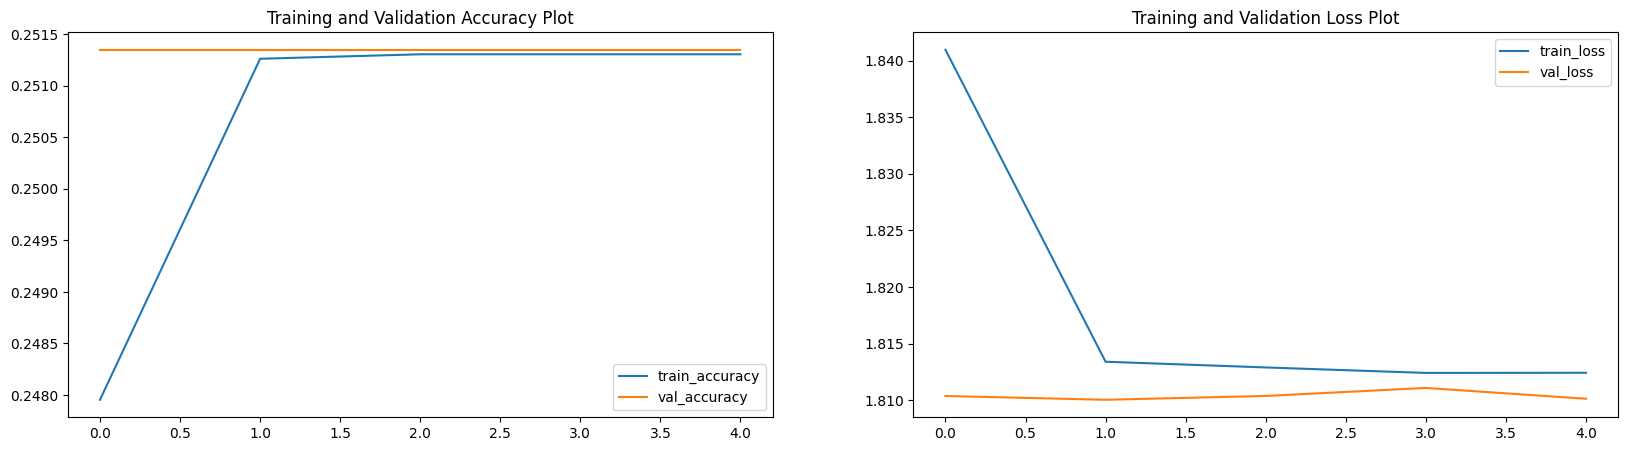

In [21]:
plotting_training_history(history)

In [22]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f"final train accuracy = {train_acc*100} , validation accuracy = {test_acc*100}")

718/718 ━━━━━━━━━━━━━━━━━━━━ 311s 433ms/step - accuracy: 0.2526 - loss: 1.8050


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.2551 - loss: 1.8114
final train accuracy = 25.13061761856079 , validation accuracy = 24.714405834674835


In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 165ms/step


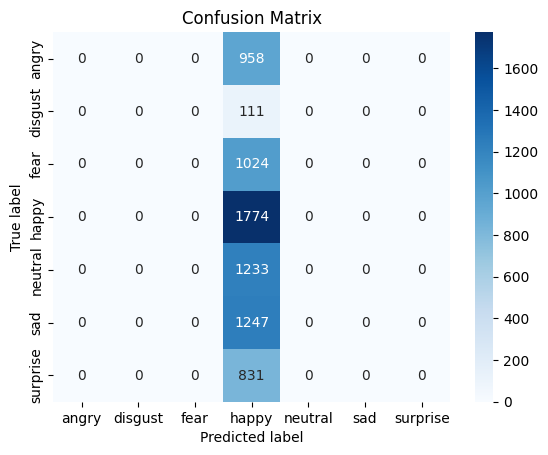

In [24]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size).astype('int')), axis=1)
class_labels = list(test_generator.class_indices.keys())

# generate confusion matrix
c_matrix = confusion_matrix(true_classes, predicted_classes)

# plotting with seaborn
sns.heatmap(c_matrix, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
# generating classification_report
# Precision is defined as the ratio of correctly classified positive samples (True Positive) to a total number of classified positive samples
# The recall measures the model's ability to detect positive samples.
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


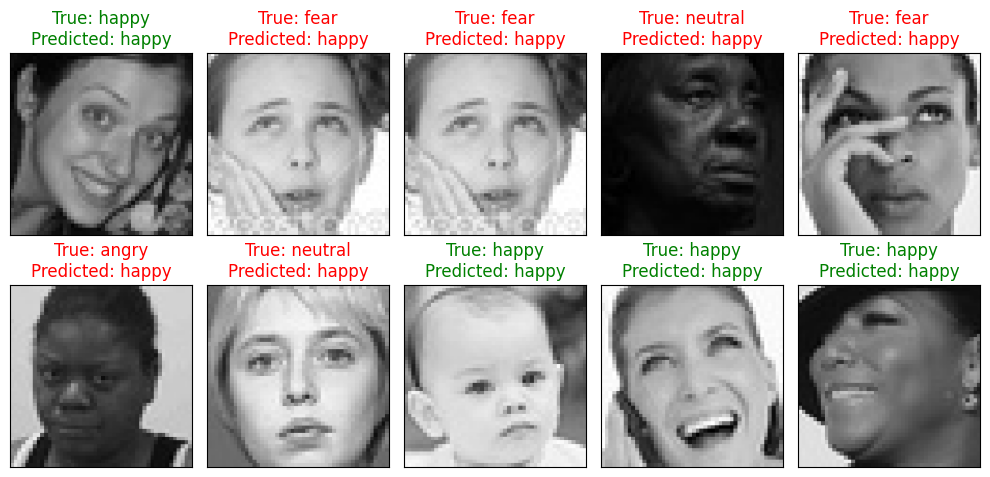

In [26]:
# Emotion classes for the dataset
emotion = class_labels

batch_size = test_generator.batch_size
# selection of random batch
random_batch = np.random.randint(0, len(test_generator)-1)
# selection of random image indices from batch_size
random_img_indices = np.random.randint(0, batch_size, 10)

# setting up plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    random_image = test_generator[random_batch][0][random_img_indices[i]]
    random_image_label = np.argmax(test_generator[random_batch][1][random_img_indices[i]])

    # making prediction over random fatched image
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_image, axis=0), verbose=0))

    # display image
    ax.imshow(random_image.squeeze(), cmap='gray')
    # Setting the title with true and predicted labels, colored based on correctness
    color = 'green' if model_prediction == random_image_label else 'red'
    ax.set_title(f"True: {emotion[random_image_label]}\nPredicted: {emotion[model_prediction]}", color=color)

plt.tight_layout()
plt.show()